# Applying ColumnTransformer to mixed column data types, and using pipelines

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

We could handle transformations directly when training the model. With ```ColumnTransform``` we can apply ```OneHotEncoder``` to categorical columns and ```RobustScaler``` (which is more robust to outliers than other transformations) to numerical columns. Let's go back to the original dataset to practice this.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data_prep/hot_plus_random.csv')

In [3]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,success
0,0.565,0.547,0.0,-7.722,1.0,0.0347,0.5790,0.000000,0.194,0.252,75.018,audio_features,1MOqMyQ7CULmWWjovkFY5B,spotify:track:1MOqMyQ7CULmWWjovkFY5B,https://api.spotify.com/v1/tracks/1MOqMyQ7CULm...,https://api.spotify.com/v1/audio-analysis/1MOq...,209320.0,4.0,1.0
1,0.578,0.894,10.0,-5.420,1.0,0.0296,0.0103,0.000003,0.216,0.741,165.980,audio_features,2dwhMQsFeHr2S787WxqAqW,spotify:track:2dwhMQsFeHr2S787WxqAqW,https://api.spotify.com/v1/tracks/2dwhMQsFeHr2...,https://api.spotify.com/v1/audio-analysis/2dwh...,347107.0,4.0,1.0
2,0.529,0.496,7.0,-9.007,1.0,0.0290,0.1730,0.000000,0.251,0.278,136.859,audio_features,3y4LxiYMgDl4RethdzpmNe,spotify:track:3y4LxiYMgDl4RethdzpmNe,https://api.spotify.com/v1/tracks/3y4LxiYMgDl4...,https://api.spotify.com/v1/audio-analysis/3y4L...,250547.0,4.0,1.0
3,0.488,0.923,2.0,-3.697,1.0,0.1030,0.1290,0.000000,0.158,0.818,183.891,audio_features,296XGtH5MeGisqD3uAz6Q6,spotify:track:296XGtH5MeGisqD3uAz6Q6,https://api.spotify.com/v1/tracks/296XGtH5MeGi...,https://api.spotify.com/v1/audio-analysis/296X...,202253.0,4.0,1.0
4,0.753,0.450,9.0,-6.909,1.0,0.0924,0.2740,0.000002,0.321,0.560,109.405,audio_features,6kD36kVRn5leDDbjXpHQY0,spotify:track:6kD36kVRn5leDDbjXpHQY0,https://api.spotify.com/v1/tracks/6kD36kVRn5le...,https://api.spotify.com/v1/audio-analysis/6kD3...,288933.0,4.0,1.0


In [4]:
df.shape

(15714, 19)

In [5]:
df.dtypes

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms         float64
time_signature      float64
success             float64
dtype: object

In [6]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'success'],
      dtype='object')

# Logistic Regression

### Using StandardScaler and OneHotEncoder (dropping the first column to avoid collinearity in logistic reg.)

In [8]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

accuracy score: 0.886
cross_val score: 0.880

               precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      1574
         1.0       0.85      0.94      0.89      1569

    accuracy                           0.89      3143
   macro avg       0.89      0.89      0.89      3143
weighted avg       0.89      0.89      0.89      3143



### Using StandardScaler and OneHotEncoder (all columns)

In [9]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

accuracy score: 0.886
cross_val score: 0.880

               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      1558
         1.0       0.85      0.95      0.89      1585

    accuracy                           0.89      3143
   macro avg       0.89      0.89      0.89      3143
weighted avg       0.89      0.89      0.89      3143



### RobustScaler and OneHotEncoder (dropping the first column to avoid collinearity)

In [10]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("\n", classification_report(y_test,clf.predict(X_test)))

accuracy score: 0.885

               precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      1540
         1.0       0.85      0.94      0.89      1603

    accuracy                           0.89      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.89      0.88      3143



### Using RobustScaler (which handles better the outliers) and OneHotEncoder() maintaining all columns

In [11]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']

numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

accuracy score: 0.879
cross_val score: 0.880

               precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      1635
         1.0       0.83      0.94      0.88      1508

    accuracy                           0.88      3143
   macro avg       0.88      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143



### For testing purposes: using OrdinalEncoding on categorical features (instead of OneHotEncoding) and StandardScaler in the rest

In [12]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

accuracy score: 0.881
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.92      0.83      0.87      1541
         1.0       0.85      0.93      0.89      1602

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.88      0.88      0.88      3143



# K-nearest neighbors Classifier

### RobustScaler and OneHotEncoder (dropping the first column to avoid collinearity)

In [12]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline
# Now we have a full prediction pipeline

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors=10, n_jobs=-1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("accuracy score: %.3f" % clf.score(X_test, y_test))
print("cross_val score: %.3f" % cross_val_score(clf,X,y,cv=5,scoring="accuracy", n_jobs=-1).mean())
print("\n", classification_report(y_test,clf.predict(X_test)))

accuracy score: 0.883
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      1574
         1.0       0.85      0.93      0.89      1569

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143



### Using pipelines with GridSearchCV

Reference: https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

In [32]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__n_neighbors': np.arange(4,100)}


CV = GridSearchCV(clf, param_grid, n_jobs=-1)

CV.fit(X_train, y_train)
print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

best params:  {'classifier__n_neighbors': 12}
best score: 0.880
accuracy score: 0.885
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      1596
         1.0       0.83      0.95      0.89      1547

    accuracy                           0.88      3143
   macro avg       0.89      0.89      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 4.37 s, sys: 220 ms, total: 4.59 s
Wall time: 9min 29s


# Support Vector Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

In [35]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__C': [.1, 1, 10, 100],
             'classifier__gamma': ['auto'],
              'classifier__tol': [.001]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

AttributeError: 'GridSearchCV' object has no attribute 'named_steps'

# Decision Tree Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

In [31]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__max_depth': np.arange(2,20),
              'classifier__min_samples_leaf': np.arange(0,100)}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

KeyboardInterrupt: 

# Random Forest Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

In [54]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__n_estimators': [50, 100, 150, 200, 250],
              'classifier__max_features': ['auto', 'sqrt', 'log2'],
              'classifier__max_depth': [10, 15, 20, 25, 30],
              'classifier__criterion': ['gini', 'entropy'],
              'classifier__random_state': [0]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)
print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

best params:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 25, 'classifier__max_features': 'auto', 'classifier__n_estimators': 150, 'classifier__random_state': 0}
best score: 0.904
accuracy score: 0.905

               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      1584
         1.0       0.87      0.95      0.91      1559

    accuracy                           0.90      3143
   macro avg       0.91      0.91      0.90      3143
weighted avg       0.91      0.90      0.90      3143

CPU times: user 7.45 s, sys: 267 ms, total: 7.71 s
Wall time: 5min 14s


# XGBoost Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

In [38]:
%%time

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from xgboost.sklearn import XGBClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

best params:  {'classifier__colsample_bytree': 1, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.906
accuracy score: 0.902

               precision    recall  f1-score   support

         0.0       0.95      0.85      0.89      1550
         1.0       0.87      0.95      0.91      1593

    accuracy                           0.90      3143
   macro avg       0.91      0.90      0.90      3143
weighted avg       0.91      0.90      0.90      3143

CPU times: user 21.2 s, sys: 65.9 ms, total: 21.2 s
Wall time: 6min 52s


In [46]:
print(CV.best_estimator_.named_steps['classifier'].feature_importances_)

[0.02239968 0.02511271 0.39910913 0.03715391 0.03506899 0.07330597
 0.05469329 0.03799661 0.01372736 0.05594879 0.01362833 0.01372393
 0.01152081 0.01308306 0.01408388 0.01066722 0.01021073 0.011515
 0.00986056 0.01371849 0.0116091  0.01771457 0.00924968 0.02702596
 0.03787319 0.01999911]


In [47]:
print(CV.best_estimator_.named_steps['classifier'].get_booster().get_fscore())

{'f2': 2271, 'f3': 2333, 'f5': 1679, 'f9': 2216, 'f6': 1625, 'f7': 1791, 'f1': 1627, 'f0': 1682, 'f10': 165, 'f15': 87, 'f4': 1769, 'f8': 1335, 'f21': 211, 'f17': 58, 'f24': 148, 'f12': 42, 'f19': 24, 'f16': 89, 'f18': 35, 'f23': 58, 'f20': 14, 'f13': 37, 'f14': 26, 'f22': 30, 'f11': 37, 'f25': 20}


In [71]:
df_from_array_pipeline

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,mode_1.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,-0.248848,-0.317568,0.187861,0.749282,-0.395385,0.576671,-0.304188,-0.790323,-0.956761,0.422056,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.018433,0.353604,-0.321654,-0.082974,-0.072602,0.000000,-0.602618,1.223118,-0.388959,0.404480,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.423963,0.322072,0.273416,1.381466,-0.212619,0.003119,-0.099476,0.228495,-0.799281,0.696903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.451613,-0.254505,0.284018,-0.114943,0.247191,0.000000,-0.146597,-0.301075,-1.225012,0.014675,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.728111,-0.085586,0.025550,-0.075790,-0.105445,0.000000,-0.453403,0.572581,1.282779,0.236016,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12566,0.267281,0.506757,-0.257090,-0.080819,-0.384961,2233.289646,-0.235602,-1.058871,0.090394,-0.560540,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12567,0.640553,0.087838,-0.556798,0.167385,-0.406219,2469.200524,-0.469634,-1.205645,-0.367414,-1.593467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12568,0.087558,0.227477,-0.522025,3.127155,0.067416,0.000000,0.701571,0.451613,-1.113920,-1.367369,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12569,-0.023041,-0.677928,-1.032176,3.206178,0.216076,0.000000,0.073298,-0.658602,1.255624,-0.557353,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [68]:
print(feature_importance.sort_values(ascending=False))

loudness              0.399109
instrumentalness      0.073306
duration_ms           0.055949
liveness              0.054693
valence               0.037997
time_signature_4.0    0.037873
speechiness           0.037154
acousticness          0.035069
time_signature_3.0    0.027026
energy                0.025113
danceability          0.022400
time_signature_5.0    0.019999
mode_1.0              0.017715
key_5.0               0.014084
tempo                 0.013727
key_2.0               0.013724
key_10.0              0.013718
key_1.0               0.013628
key_4.0               0.013083
key_11.0              0.011609
key_3.0               0.011521
key_8.0               0.011515
key_6.0               0.010667
key_7.0               0.010211
key_9.0               0.009861
time_signature_1.0    0.009250
dtype: float32


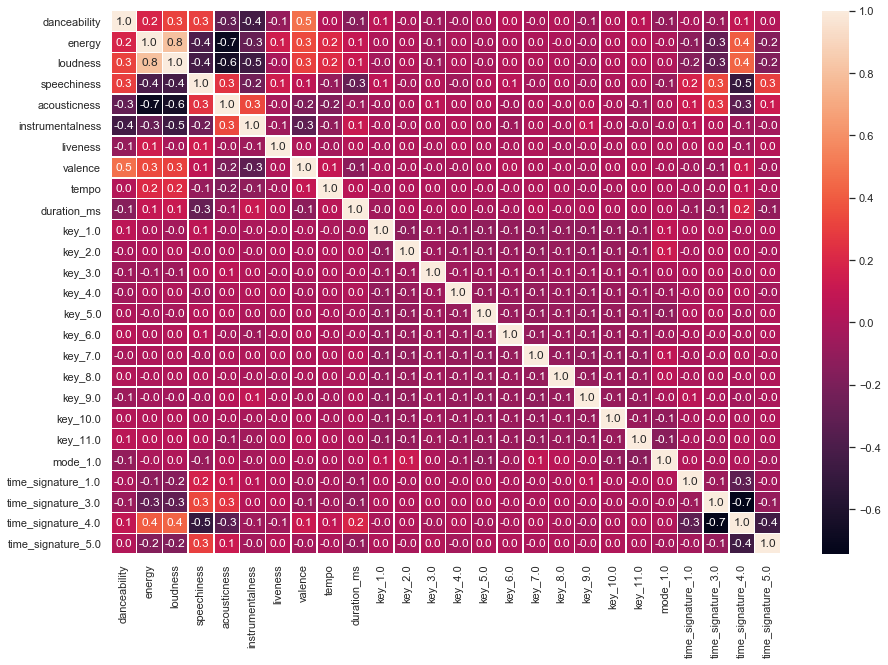

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_from_array_pipeline.corr()
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f', ax=ax);

In [94]:
%%time

# Dropping 'energy' as it shows correlation with 'loudness'

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from xgboost.sklearn import XGBClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success', 'energy'], axis=1)
y = df['success']
numeric_features = ['danceability', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

CV.fit(X_train, y_train)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

best params:  {'classifier__colsample_bytree': 1, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.901
accuracy score: 0.900

               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1598
         1.0       0.86      0.95      0.90      1545

    accuracy                           0.90      3143
   macro avg       0.90      0.90      0.90      3143
weighted avg       0.90      0.90      0.90      3143

CPU times: user 17.1 s, sys: 126 ms, total: 17.2 s
Wall time: 6min 40s
